In [3]:
# Import modules

from music21 import *
import matplotlib.pyplot as plt
plt.style.use("../graphs.mplstyle")

from calculators import *
from boundaryDetection import *
from graphUtilities import *
from annealerUtilities import *

In [4]:
# https://www.music21.org/music21docs/about/referenceCorpus.html#referencecorpus

beethoven = corpus.parse("beethoven/opus74.mxl")
excerpt = beethoven.measures(1, 13)

excerpt.show("text")
#violin.show("midi")


{0.0} <music21.stream.Part Violin I>
    {0.0} <music21.instrument.Instrument 'P1: Violin I: '>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.expressions.TextExpression 'Poco Adagio'>
        {0.0} <music21.expressions.TextExpression 'sotto voce'>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.key.Key of E- major>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.note.Note E->
        {2.0} <music21.note.Note G>
        {3.5} <music21.note.Note A->
    {0.0} <music21.spanner.Slur <music21.note.Note E-><music21.note.Note A->>
    {0.0} <music21.spanner.Slur <music21.note.Note E-><music21.note.Note A->>
    {0.0} <music21.spanner.Slur <music21.note.Note E-><music21.note.Note B->>
    {0.0} <music21.spanner.Slur <music21.note.Note B-><music21.note.Note A->>
    {0.0} <music21.spanner.Slur <music21.note.Note A-><music21.note.Note G>>
    {0.0} <music21.spanner.Slur <music21.note.Note G><music21.note.Note F>>
    {0.0} <music21.d

In [5]:
# Boundary detection

beethoven = corpus.parse("beethoven/opus74.mxl")
excerpt = beethoven.measures(1, 13)

phraseStack = []
phraseEntropies = []

for part in excerpt.parts:
    boundaries = identifyBoundaries(part, 0.4)
    print(boundaries)
    phrases = extractPhrases(part, boundaries, f"{part.id}")    
    phraseStack.append(phrases)

[2.0, 8.0, 16.0, 36.0, 52.0]
[2.0, 8.0, 12.0, 14.0, 32.0, 37.0, 52.0]
[2.0, 8.0, 12.0, 15.0, 22.0, 23.0, 24.0, 26.0, 32.0, 52.0]
[2.0, 8.0, 12.0, 16.0, 19.0, 20.0, 23.0, 24.0, 28.0, 30.0, 52.0]


In [4]:
flatStack = [phrase for phrases in phraseStack for phrase in phrases]
print(len(flatStack))

for p in flatStack: print(p.id, p.entropy)

uniquePairs = [(i, j) for i in range(len(flatStack)) for j in range(i+1, len(flatStack))]

#for i, j in uniquePairs: print(flatStack[i].id, flatStack[j].id, hasOverlap(flatStack[i], flatStack[j]))

33
Violin I_1 -0.0
Violin I_2 3.169925001442312
Violin I_3 4.0
Violin I_4 4.75719074674169
Violin I_5 3.8079356261755315
Violin II_1 -0.0
Violin II_2 1.584962500721156
Violin II_3 2.5032583347756456
Violin II_4 -0.0
Violin II_5 3.5626344188865966
Violin II_6 -0.0
Violin II_7 3.819149072372205
Viola_1 -0.0
Viola_2 3.169925001442312
Viola_3 2.5032583347756456
Viola_4 -0.0
Viola_5 2.4928786893420307
Viola_6 -0.0
Viola_7 -0.0
Viola_8 -0.0
Viola_9 3.169925001442312
Viola_10 2.2747043575713755
Violoncello_1 -0.0
Violoncello_2 3.169925001442312
Violoncello_3 3.169925001442312
Violoncello_4 -0.0
Violoncello_5 -0.0
Violoncello_6 -0.0
Violoncello_7 -0.0
Violoncello_8 -0.0
Violoncello_9 -0.0
Violoncello_10 -0.0
Violoncello_11 4.256662099534205


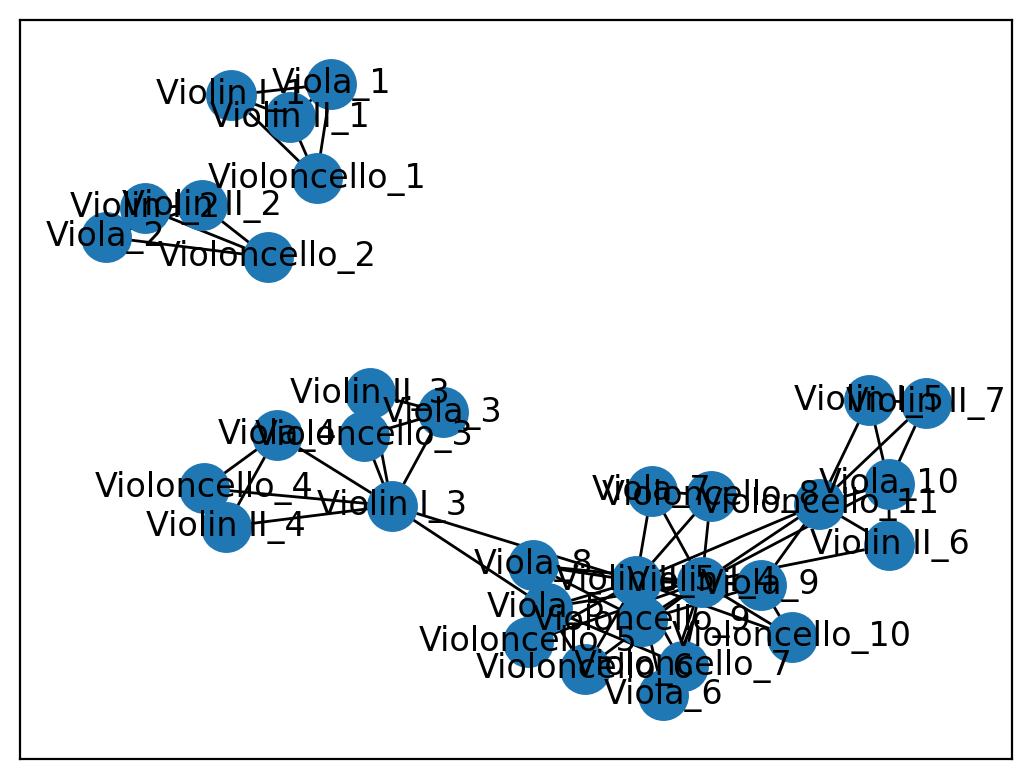

In [5]:
edges = []

for i, j in uniquePairs:
    if hasOverlap(flatStack[i], flatStack[j]):
        edges.append((flatStack[i].id, flatStack[j].id))

# TODO: How to weight size of nodes by their entropy?
G = defineGraph(edges)
pos = nx.spring_layout(G, k=0.5) # Force specific layout
plotGraph(G, pos)

In [6]:
# Solve on QPU

phraseEntropies = [(phrase.id, phrase.entropy) for phrase in flatStack]

df = solveWeightedMIS(G, phraseEntropies, num_reads=1000)

                                              sample     energy  \
0  {'Viola_1': 0, 'Viola_10': 0, 'Viola_2': 0, 'V... -15.821803   
1  {'Viola_1': 0, 'Viola_10': 0, 'Viola_2': 0, 'V... -15.821803   
2  {'Viola_1': 0, 'Viola_10': 0, 'Viola_2': 1, 'V... -15.821803   
3  {'Viola_1': 0, 'Viola_10': 0, 'Viola_2': 0, 'V... -15.821803   
4  {'Viola_1': 0, 'Viola_10': 0, 'Viola_2': 1, 'V... -15.821803   

   num_occurrences  chain_break_fraction  
0                1              0.030303  
1                1              0.030303  
2                1              0.030303  
3                1              0.030303  
4                1              0.030303  
0     -15.821803
397   -15.821803
398   -15.821803
399   -15.821803
400   -15.821803
         ...    
945    -8.562823
946    -8.344883
947    -7.803329
948    -7.426587
949    -3.147876
Name: energy, Length: 950, dtype: float64
['Viola_5', 'Viola_7', 'Viola_8', 'Viola_9', 'Violin II_4', 'Violin II_7', 'Violin I_2', 'Violoncello_3']
8


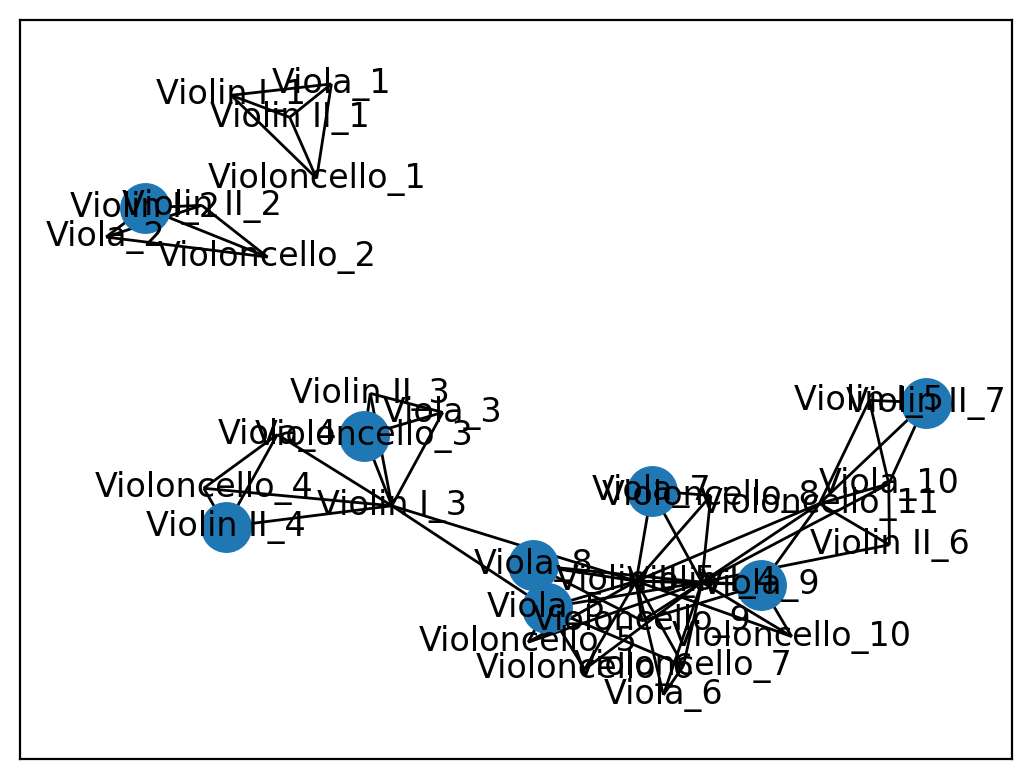

In [7]:
print(df.head())
print(df["energy"].sort_values(ascending=True))

sample = df["sample"][0]
chosen = [x for x in sample if sample[x] == 1]

print(chosen)
print(len(chosen))

plotGraph(G, pos, nodeList=chosen)

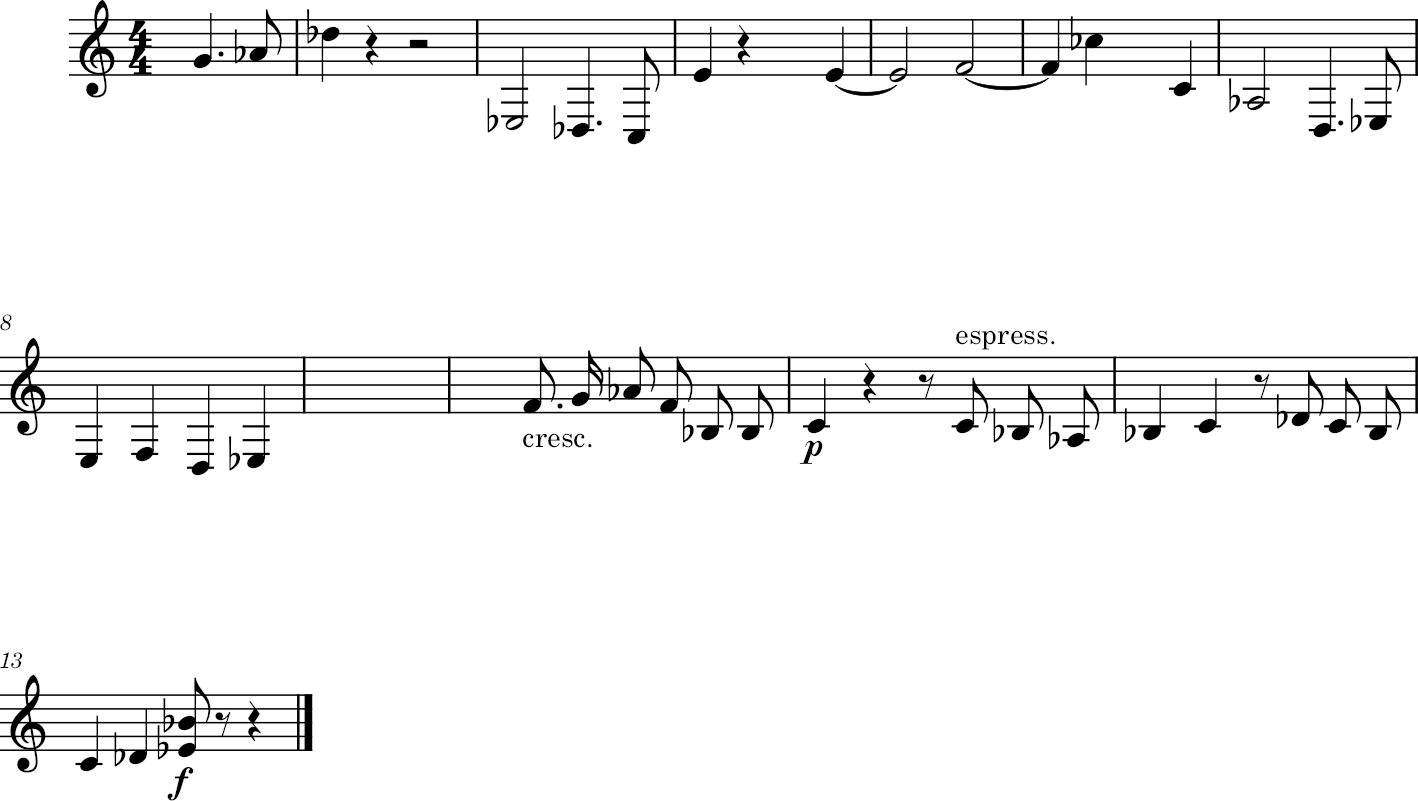

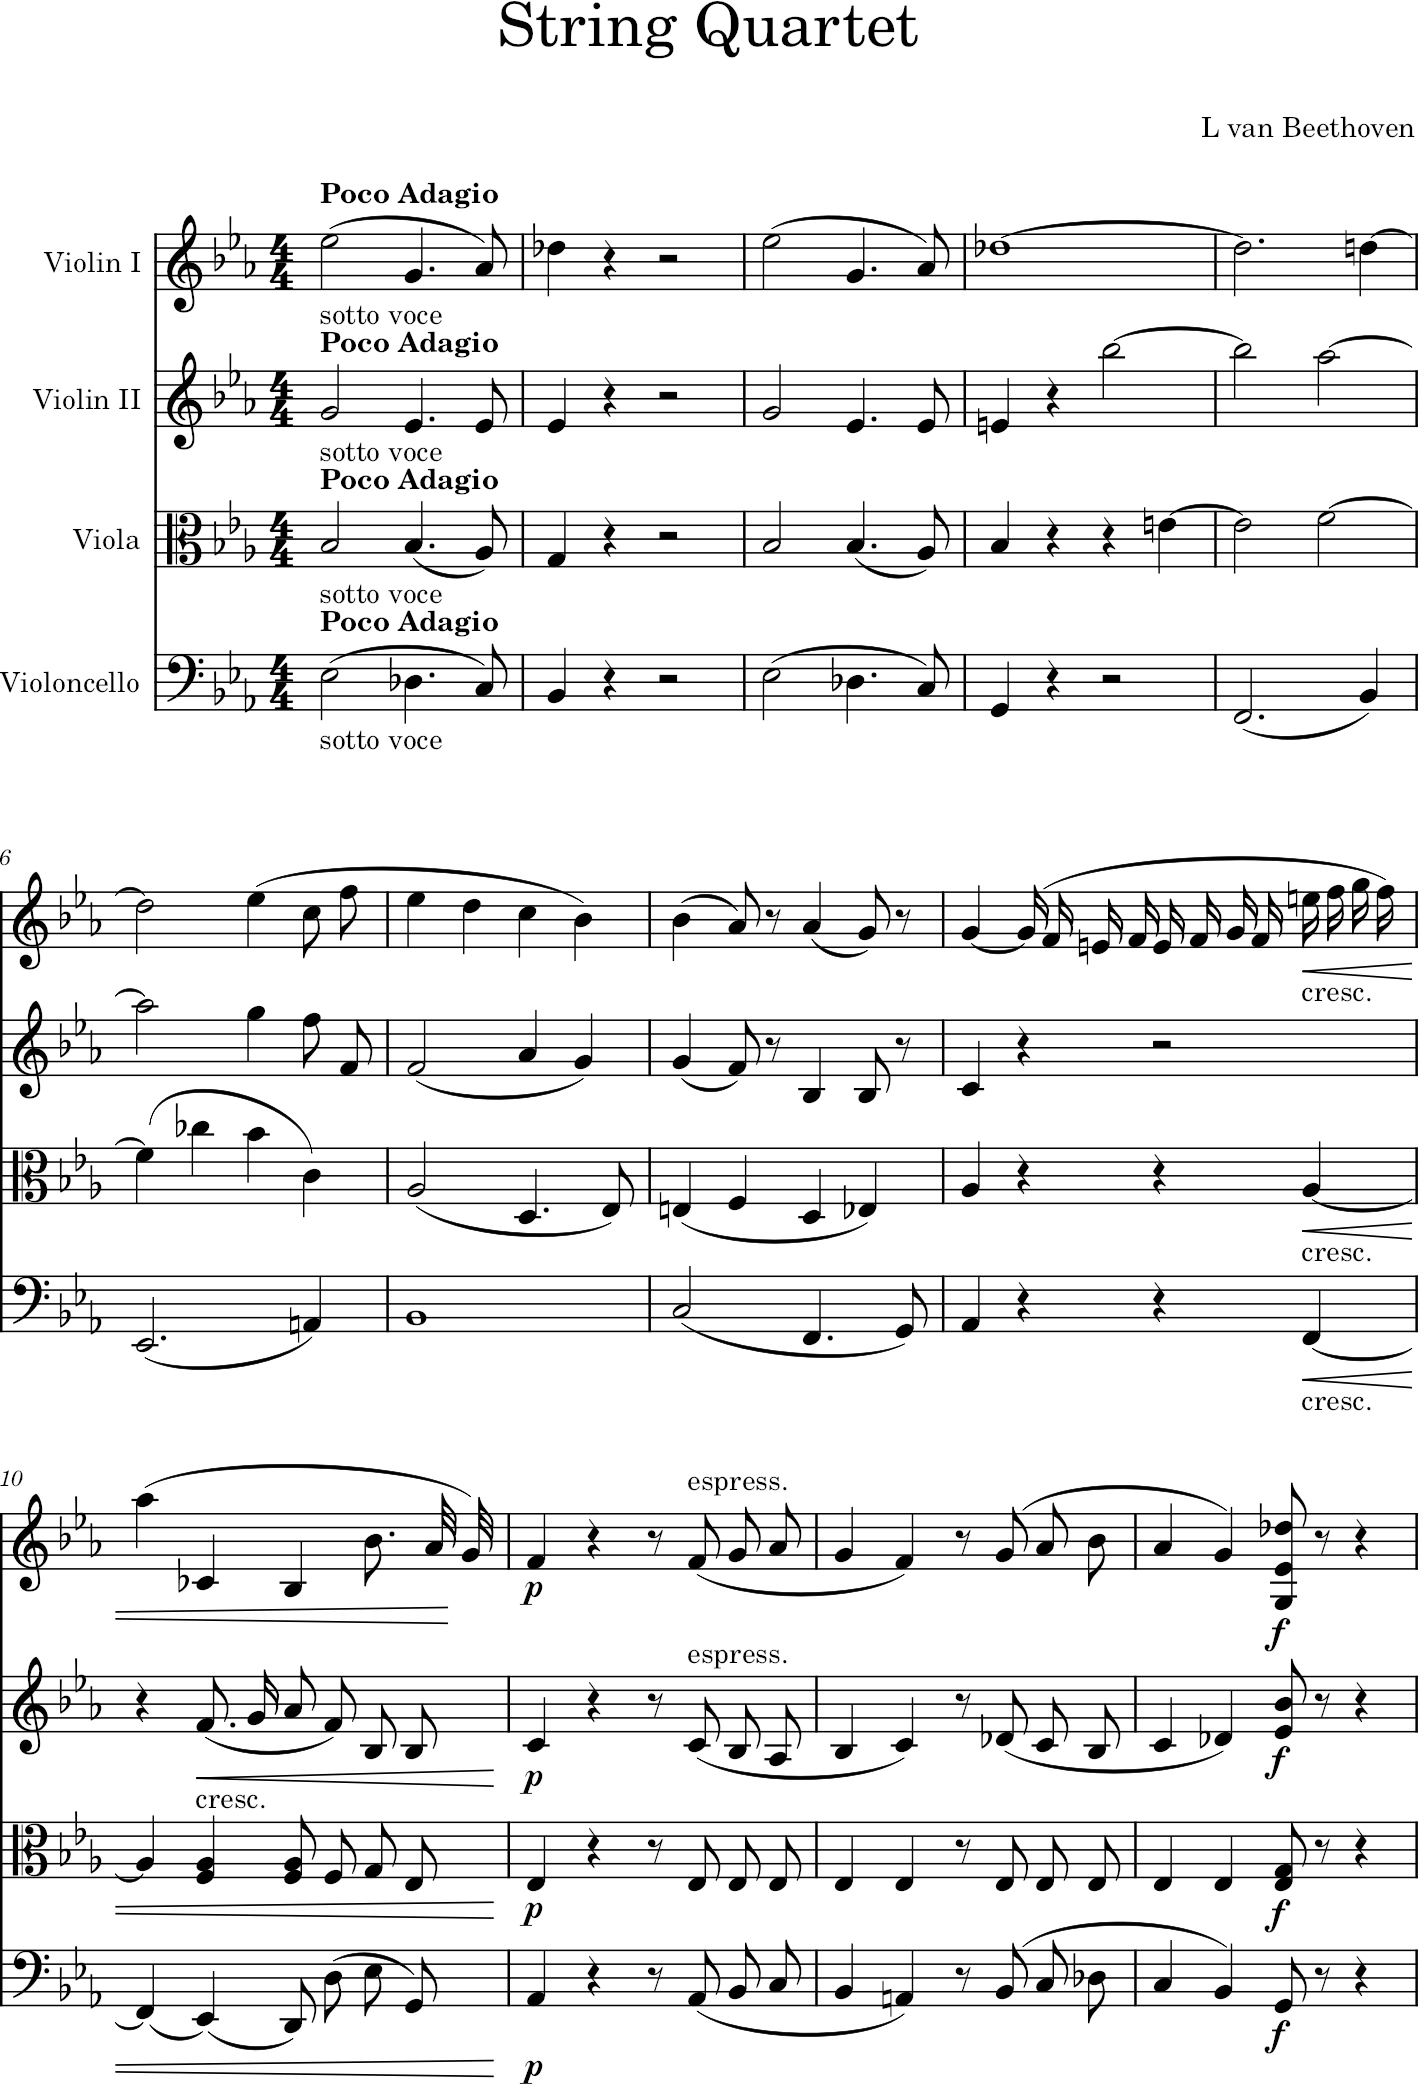

In [8]:
arrangement = stream.Stream()

for phrase in flatStack:
    if phrase.id in chosen:
        arrangement.mergeElements(phrase)

arrangement.show()
arrangement.show("midi")
excerpt.show()

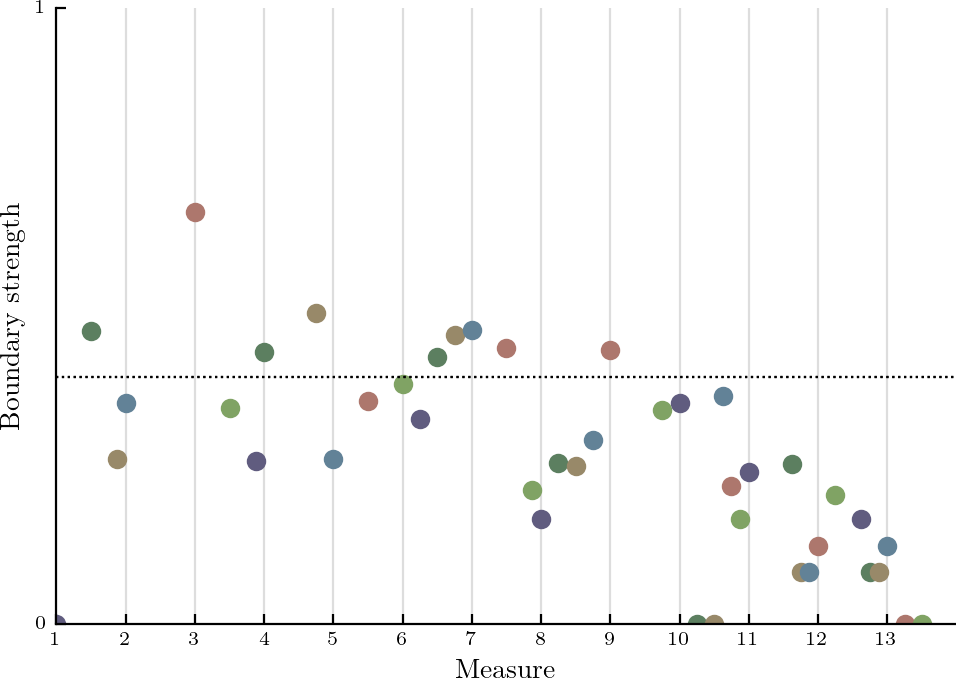

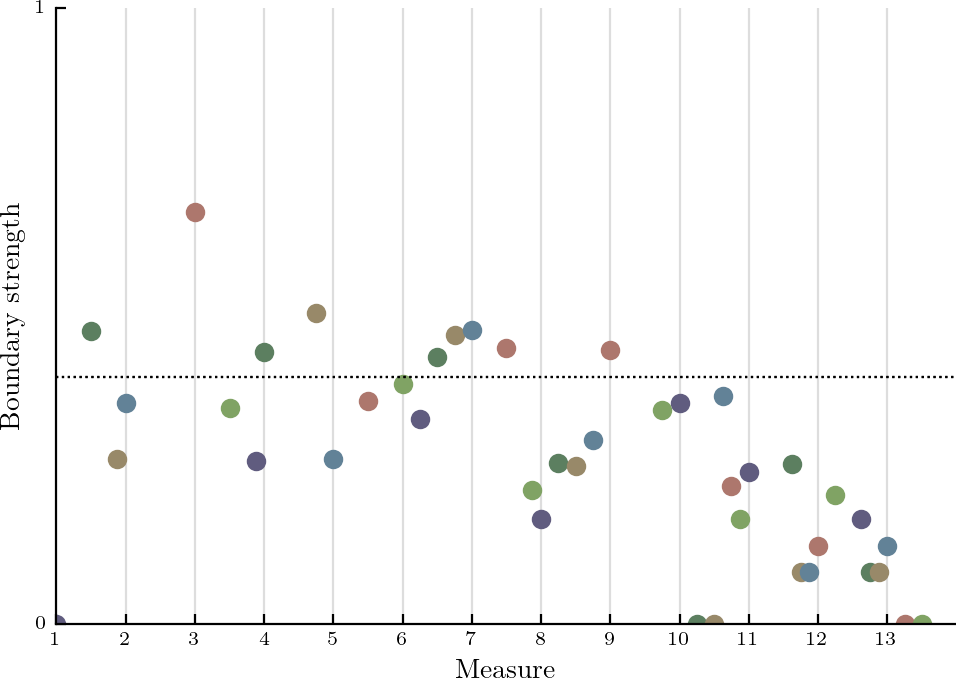

In [64]:
class BoundaryStrengthAxis(graph.axis.Axis):
    labelDefault = 'Boundary strength'

    def __init__(self, client=None, axisName='y'):
        super().__init__(client, axisName)
        self.minValue = 0
        self.maxValue = 1

    def ticks(self):
        ticks = super().ticks()
        tickValues = [0,1]
        newTicks = [(0,0), (1,1)]
        return newTicks

    def extractOneElement(self, el, formatDict):
        if hasattr(el, 'boundaryStrength'):
            return el.boundaryStrength

viola = excerpt.parts[2]
plotS = graph.plot.Scatter(viola, marker="o")

plotS.axisX = graph.axis.OffsetAxis(plotS, 'x')
plotS.axisY = BoundaryStrengthAxis(plotS, 'y')
plotS.title = ""
plotS.figureSize = (6,4)

plotS.alpha = 1
plotS.doneAction = None
plotS.axisX.label = "Measure"
plotS.hideYGrid = True

plotS.run()

line = plt.hlines(0.4, 0, viola.quarterLength, linestyles=":", colors="black")
plotS.subplot.add_artist(line)
plotS.subplot.set_xlim(left=0, right=viola.quarterLength)
plotS.subplot.set_ylim(bottom=0, top=1)

#plotS.write()
plotS.write(fp="..\\Figures\\boundary_offset.pdf")

In [1]:
class EntropyAxis(graph.axis.Axis):
    labelDefault = 'Entropy'

    def extractOneElement(self, el, formatDict):
        if hasattr(el, 'name'):
            return noteEntropy(el)
        
plotS = graph.plot.Scatter(excerpt.parts[0])

plotS.title = 'Offset vs Entropy'
plotS.axisX = graph.axis.OffsetAxis(plotS, 'x')
plotS.axisY = EntropyAxis(plotS, 'y')

plotS.run()

NameError: name 'graph' is not defined